# Voice recognition - natural and synthetic adults

First, we import the necessary libraries

In [2]:
import numpy as np
from matplotlib import pyplot as pl
import os
import re
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

Then, we read the .wav files and create the dataset

In [4]:

PATH = 'vowels/'
PATTERN = r"^(n|s)a(m|f)[^\\\/]+.wav$"

filenames = list(filter(lambda x : re.search(PATTERN, x) is not None, (filename for filename in os.listdir(PATH))))

dataset = []

for filename in filenames:
    sample_rate, X = wav.read(os.path.join(PATH,filename))
    ceps = mfcc(X, samplerate=sample_rate, nfft=1024).mean(axis=0)

    # Add class to the data
    ceps = np.append(ceps, 1 if filename[2] == "m" else -1)

    # Add to dataset
    dataset.append(ceps)

dataset = np.array(dataset)
print(dataset)

[[ 20.83553285  13.14986301  -9.66938018 ... -19.36086468 -16.14554454
   -1.        ]
 [ 21.08101329   4.73696633  -9.2959752  ... -23.62248603 -11.13881792
   -1.        ]
 [ 21.20387031  13.72238626  -8.3806115  ... -10.52878694  -3.11467664
   -1.        ]
 ...
 [ 19.4462284   21.56810529 -16.84306496 ...  14.79303457  -1.71013954
    1.        ]
 [ 19.62277608  21.38610436  -7.83683509 ...  14.85976728   5.52514236
    1.        ]
 [ 19.36807181  25.49020179   1.13495435 ...  10.86799868  11.25078998
    1.        ]]


Decide the neural network parameters

In [5]:
N_INITS = 10
EPOCHS = 200
N_NEURONS = [2, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

Do a basic training with several amounts of neurons to see the necessary amount of epochs until the error stops evolving

In [6]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)
print('Done !')

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
Done !


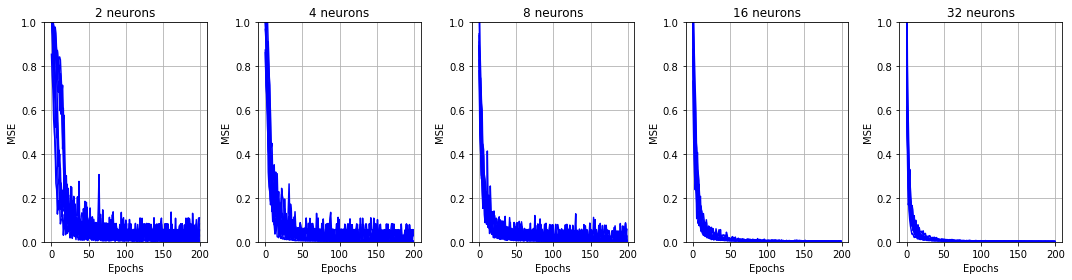

In [7]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

Here we can see that after 80 epochs the MSE does not evolve much anymore.

We will now explore more deeply the amount of neurons needed for the model. For that, we will use cross-validation.

In [8]:
EPOCHS = 80
K = 5
N_TESTS = 10
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]

In [9]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2
print('Done !')

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...
Done !


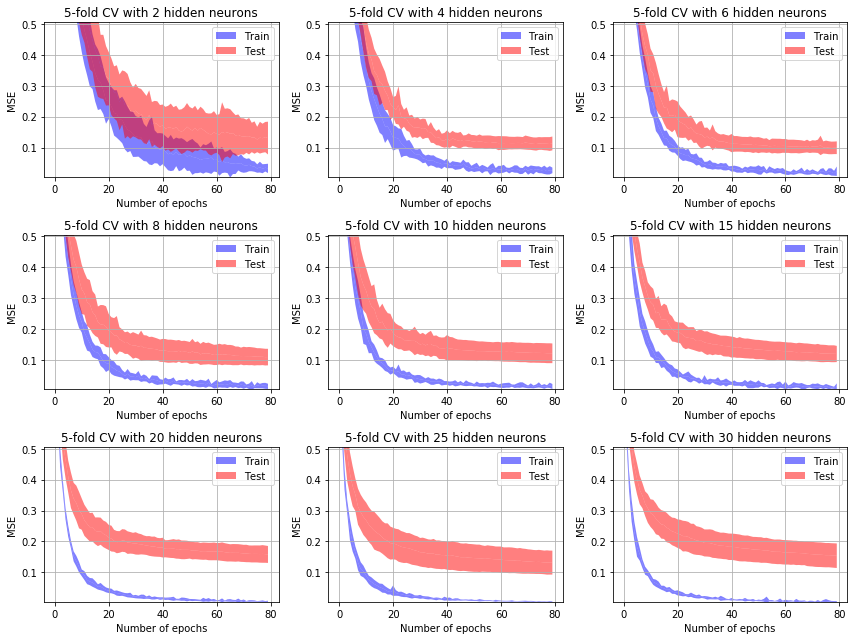

In [12]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

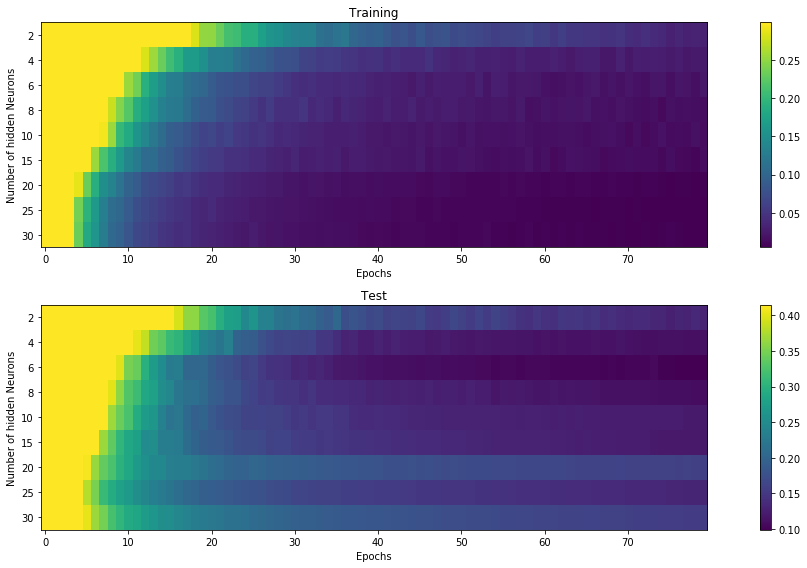

In [26]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

Acording to those results, 6 neurons is clearly the best choice here.

Our training parameters are:
Epoch = 80
Momentum = 0.5
Learning rate = 0.001
nb hidden neurons = 6

If we train our network several times with these parameters, we get an MSE between 0.07 and 0.13.


In [24]:
nn = mlp.MLP([13,6,1], 'tanh')
MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=80,
                                                          threshold=0.0)

In [25]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.02295516536981417
MSE test:  0.08513430076631145
Confusion matrix:
[[69.  3.]
 [ 1. 71.]]
